[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 5
[LightGBM] [Info] Start training from score 100.214019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

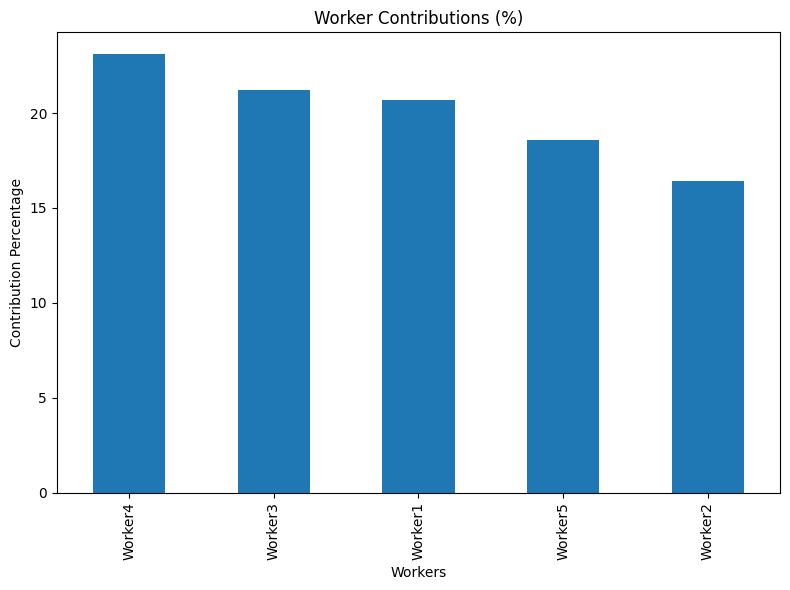

In [4]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

def load_data(file_path):
    return pd.read_csv(file_path, index_col=0, parse_dates=True)

def preprocess_data(data):
    """
    Simplifies preprocessing: includes only lag1 features.
    """
    # Create lag1 features
    for worker in data.columns[:5]:
        data[f'{worker}_lag1'] = data[worker].shift(1)

    data.dropna(inplace=True)  # Drop rows with missing lagged values

    # Use lagged features as inputs and total productivity as the target
    X = data.drop(columns=data.columns[:5])  # Features: lagged values only
    y = data.iloc[:, :5].sum(axis=1)  # Target: total productivity

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    feature_names = X.columns.tolist()

    return X_scaled, y, scaler, feature_names

def train_model(X, y):
    """
    Simplified LightGBM model to avoid overfitting.
    """
    model = LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X, y)
    return model

def compute_shap_values(model, X):
    """
    Compute Shapley values using TreeSHAP.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    return explainer, shap_values

def calculate_worker_contributions(shap_values, feature_names):
    """
    Aggregate Shapley values back to worker-level contributions.
    """
    worker_shap_values = {worker: 0 for worker in set(f.split('_')[0] for f in feature_names)}

    # Aggregate contributions for each worker
    for i, feature in enumerate(feature_names):
        original_worker = feature.split('_')[0]
        worker_shap_values[original_worker] += np.mean(np.abs(shap_values[:, i]))

    # Normalize contributions to percentages
    total_contributions = sum(worker_shap_values.values())
    contributions = {worker: (value / total_contributions) * 100 for worker, value in worker_shap_values.items()}

    return pd.Series(contributions)

def visualize_global_contributions(worker_contributions):
    """
    Visualize global contributions as a bar chart.
    """
    worker_contributions.sort_values(ascending=False).plot(kind='bar', figsize=(8, 6))
    plt.title("Worker Contributions (%)")
    plt.ylabel("Contribution Percentage")
    plt.xlabel("Workers")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    data = load_data("synthetic_validation_dataset.csv")

    # Simplified preprocessing
    X, y, scaler, feature_names = preprocess_data(data)

    # Train the simplified LightGBM model
    model = train_model(X, y)

    # Validate model performance
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print("Cross-Validation RMSE:", np.sqrt(-scores.mean()))

    # Compute Shapley values
    explainer, shap_values = compute_shap_values(model, X)

    # Calculate worker contributions
    worker_contributions = calculate_worker_contributions(shap_values, feature_names)
    print("\nWorker Contributions (as percentages):")
    print(worker_contributions)

    # Visualize global contributions
    visualize_global_contributions(worker_contributions)
